# Variational Autoencoder

In this assignment, you will build Variational Autoencoder, train it on the MNIST dataset, and play with its architecture and hyperparameters.

### Installation

You will need ```numpy```, ```tensorflow```, ```keras```, ```matplotlib``` libraries for this assignment

In [1]:
! pip3 install tensorflow

    100% |████████████████████████████████| 51.1MB 22kB/s 
    100% |████████████████████████████████| 7.1MB 164kB/s 
    100% |████████████████████████████████| 13.8MB 84kB/s 
    100% |████████████████████████████████| 9.3MB 121kB/s 
    100% |████████████████████████████████| 92kB 7.0MB/s 
    100% |████████████████████████████████| 3.3MB 365kB/s 
    100% |████████████████████████████████| 327kB 3.5MB/s 
    100% |████████████████████████████████| 81kB 9.3MB/s 
  Running setup.py bdist_wheel for termcolor ... - \ done
  Stored in directory: /home/jovyan/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Running setup.py bdist_wheel for gast ... - \ done
  Stored in directory: /home/jovyan/.cache/pip/wheels/9a/1f/0e/3cde98113222b853e98fc0a8e9924480a3e25f1b4008cedb4f
  Running setup.py bdist_wheel for absl-py ... - \ done
  Stored in directory: /home/jovyan/.cache/pip/wheels/4c/16/ef/e36a23f2432e9220f8845f94e2c3abd39e7d9d1cd458d3159d
Successfu

In [2]:
! pip3 install keras

    100% |████████████████████████████████| 307kB 3.1MB/s 
    100% |████████████████████████████████| 51kB 7.5MB/s 
You are using pip version 8.1.2, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
! conda install pyqt=4 --y

Fetching package metadata .........
Solving package specifications: ..........

Package plan for installation in environment /opt/conda:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    jpeg-8d                    |                2         806 KB
    qt-4.8.7                   |                4        32.7 MB
    pyqt-4.11.4                |           py35_4         3.3 MB
    ------------------------------------------------------------
                                           Total:        36.8 MB

The following NEW packages will be INSTALLED:

    pyqt: 4.11.4-py35_4
    qt:   4.8.7-4      

The following packages will be UPDATED:

    jpeg: 8d-1          --> 8d-2

Fetching packages ...
jpeg-8d-2.tar. 100% |################################| Time: 0:00:00  29.20 MB/s
qt-4.8.7-4.tar 100% |################################| Time: 0:00:00  37.05 MB/s
pyqt-4.11.4-py 100% |################

In [72]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from grader import Grader
%matplotlib inline

### Grading
We will create a grader instance below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to the platform only after running submit function in the last part of this assignment. If you want to make a partial submission, you can run that cell anytime you want.

In [73]:
grader = Grader()

### Variational Autoencoder

Recall that Variational Autoencoder is a probabilistic model of data based on a continious mixture of distributions. In the lecture we covered the mixture of gaussians case, but here we will apply VAE to binary MNIST images (each pixel is either black or white). To better model binary data we will use a continuous mixture of binomial distributions: $p(x \mid w) = \int p(x \mid t, w) p(t) dt$, where the prior distribution on the latent code $t$ is standard normal $p(t) = \mathcal{N}(0, I)$, but probability that $(i, j)$-th pixel is black equals to $(i, j)$-th output of the decoder neural detwork: $p(x_{i, j} \mid t, w) = \text{decoder}(t, w)_{i, j}$.

To train this model we would like to maximize marginal log-likelihood of our dataset $\max_w \log p(X \mid w)$, but it's very hard to do computationally, so instead we maximize the Variational Lower Bound w.r.t. both the original parameters $w$ and variational distribution $q$ which we define as encoder neural network with parameters $\phi$ which takes input image $x$ and outputs parameters of the gaussian distribution $q(t \mid x, \phi)$: $\log p(X \mid w) \geq \mathcal{L}(w, \phi) \rightarrow \max_{w, \phi}$.

So overall our model looks as follows: encoder takes an image $x$, produces a distribution over latent codes $q(t \mid x)$ which should approximate the posterior distribution $p(t \mid x)$ (at least after training), samples a point from this distribution $\widehat{t} \sim q(t \mid x, \phi)$, and finally feeds it into a decoder that outputs a distribution over images.

![](VAE.png)

In the lecture, we also discussed that variational lower bound has an expected value inside which we are going to approximate with sampling. But it is not trivial since we need to differentiate through this approximation. However, we learned about _reparametrization trick_ which suggests instead of sampling from distribution $\widehat{t} \sim q(t \mid x, \phi)$ sample from a distribution which doesn't depend on any parameters, e.g. standard normal, and then deterministically transform this sample to the desired one: $\varepsilon \sim \mathcal{N}(0, I); ~~\widehat{t} = m(x, \phi) + \varepsilon \sigma(x, \phi)$. This way we don't have to worry about our stochastic gradient being biased and can straightforwardly differentiate our loss w.r.t. all the parameters while treating the current sample $\varepsilon$ as constant.




### Variational Lower Bound

**Task 1** Derive and implement Variational Lower Bound for the continuous mixture of Binomial distributions.

**Note** that to pass the test, your code should work with any mini-batch size.

**Also note** that although we need a stochastic estimate of VLB: 
$$\text{VLB} = \sum_{i=1}^N \text{VLB}_i \approx \frac{N}{M}\sum_{i_s}^M \text{VLB}_{i_s}$$
where $N$ is the dataset size, $\text{VLB}_i$ is the term of VLB corresponding to the $i$-th object, and $M$ is the mini-batch size; in the function below you need to return just average across the mini-batch $\frac{1}{M}\sum_{i_s}^M \text{VLB}_{i_s}$. People usually optimize this unscaled version of VLB since it doesn't depend on the dataset set size - you can write VLB function once and use it for different datasets - and it doesn't affect optimization (it does affect the learning rate though). The correct value for this unscaled VLB should be around $100 - 170$.

In [74]:
def vlb_binomial(x, x_decoded_mean, t_mean, t_log_var):
    """Returns the value of Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """
    ### YOUR CODE HERE
    klterm=0.5*K.sum(-1-t_log_var+K.square(t_mean)+K.exp(t_log_var),axis=1)#batch_size
    reconst=K.sum(K.binary_crossentropy(x,x_decoded_mean),axis=1)
    return K.mean(klterm+reconst)

In [75]:
# Start tf session so we can run code.
sess = tf.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

/opt/conda/lib/python3.5/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [76]:
grader.submit_vlb(sess, vlb_binomial)

Current answer for task 1 (vlb) is: 157.59676


## Encoder / decoder definition

**Task 2** Read the code below that defines encoder and decoder networks and implement sampling with reparametrization trick in the provided space.

In [82]:
batch_size = 100
original_dim = 784 # Number of pixels in MNIST images.
latent_dim = 60 # d, dimensionality of the latent code t.
intermediate_dim = 512 # Size of the hidden layer.
epochs = 30

x = Input(batch_shape=(batch_size, original_dim))
def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim]))
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Dense(2 * latent_dim))
    return encoder
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])
h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    # YOUR CODE HERE
    epsilon=K.random_normal(t_mean.shape)
    z=epsilon*K.exp(0.5*t_log_var)+t_mean
    return z


t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim, activation='relu'))
    decoder.add(Dense(original_dim, activation='sigmoid'))
    return decoder
decoder = create_decoder(latent_dim)
x_decoded_mean = decoder(t)

In [83]:
grader.submit_samples(sess, sampling)

Current answer for task 2.1 (samples mean) is: -0.122846134
Current answer for task 2.2 (samples var) is: 0.036452327


## Training the model

**Task 3** Run the cells below to train the model with the default settings. Modify the parameters to get better results. Especially pay attention the encoder / encoder architectures (e.g. using more layers, maybe making them convolutional), learning rate, and the number of epochs.

In [84]:
loss = vlb_binomial(x, x_decoded_mean, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
# Keras will provide input (x) and output (x_decoded_mean) to the function that
# should construct loss, but since our function also depends on other
# things (e.g. t_means), it is easier to build the loss in advance and pass
# a function that always returns it.
vae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: loss)

#### Load and prepare the data

In [85]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# One hot encoding.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#### Train the model

In [86]:
hist = vae.fit(x=x_train, y=x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_test, x_test),
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
 - 21s - loss: 155.2886 - val_loss: 130.4840
Epoch 2/30
 - 20s - loss: 125.8111 - val_loss: 121.0021
Epoch 3/30
 - 20s - loss: 117.5763 - val_loss: 113.3977
Epoch 4/30
 - 20s - loss: 113.4917 - val_loss: 110.7886
Epoch 5/30
 - 21s - loss: 111.1456 - val_loss: 108.8744
Epoch 6/30
 - 20s - loss: 109.6594 - val_loss: 107.9150
Epoch 7/30
 - 20s - loss: 108.6617 - val_loss: 107.4443
Epoch 8/30
 - 20s - loss: 107.9294 - val_loss: 108.4722
Epoch 9/30
 - 20s - loss: 107.3812 - val_loss: 106.2369
Epoch 10/30
 - 20s - loss: 106.9576 - val_loss: 106.3457
Epoch 11/30
 - 20s - loss: 106.5930 - val_loss: 106.6863
Epoch 12/30
 - 20s - loss: 106.2449 - val_loss: 105.6120
Epoch 13/30
 - 21s - loss: 105.9748 - val_loss: 105.0381
Epoch 14/30
 - 22s - loss: 105.7442 - val_loss: 104.9915
Epoch 15/30
 - 21s - loss: 105.5459 - val_loss: 105.2390
Epoch 16/30
 - 20s - loss: 105.3548 - val_loss: 105.0469
Epoch 17/30
 - 20s - loss: 105.2780 - val_loss:

### Visualize reconstructions for train and validation data
In the picture below you can see the reconstruction ability of your network on training and validation data. In each of the two images, the left column is MNIST images and the right column is the corresponding image after passing through autoencoder (or more precisely the mean of the binomial distribution over the output images).

Note that getting the best possible reconstruction is not the point of VAE, the KL term of the objective specifically hurts the reconstruction performance. But the reconstruction should be anyway reasonable and they provide a visual debugging tool.

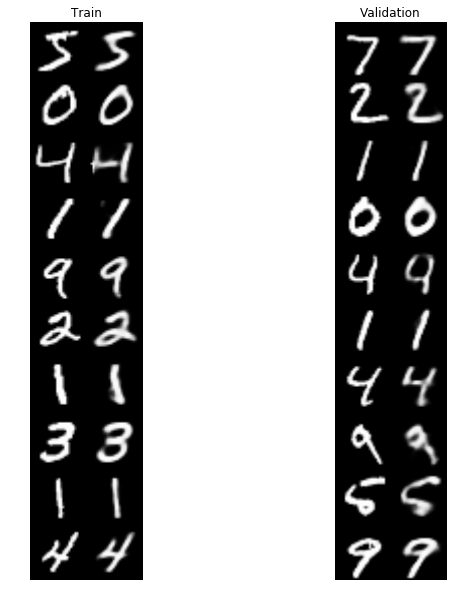

In [88]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (data, title) in enumerate(
            zip([x_train, x_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(x_decoded_mean, feed_dict={x: data[:batch_size, :]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

### Sending the results of your best model as Task 3 submission

In [89]:
grader.submit_best_val_loss(hist)

Current answer for task 3 (best val loss) is: 103.95122276306152


## Hallucinating new data
**Task 4** Write code to generate new samples of images from your trained VAE. To do that you have to sample from the prior distribution $p(t)$ and then from the likelihood $p(x \mid t)$.

**Note** that the sampling you've written in Task 2 was for the variational distribution $q(t \mid x)$, while here you need to sample from the prior.

In [90]:
n_samples = 10  # To pass automatic grading please use at least 2 samples here.
# YOUR CODE HERE.
# ...
# sampled_im_mean is a tf.Tensor of size 10 x 784 with 10 random
# images sampled from the vae model.
z=K.random_normal((n_samples,latent_dim))
sampled_im_mean = decoder(z)

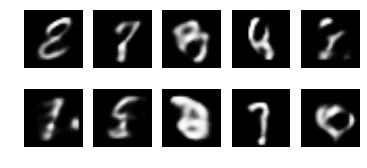

In [91]:
sampled_im_mean_np = sess.run(sampled_im_mean)
# Show the sampled images.
plt.figure()
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(sampled_im_mean_np[i, :].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()

In [92]:
grader.submit_hallucinating(sess, sampled_im_mean)

Current answer for task 4.1 (hallucinating mean) is: 0.11096026
Current answer for task 4.2 (hallucinating var) is: 0.17545667


# Conditional VAE

In the final task, you will modify your code to obtain Conditional Variational Autoencoder [1]. The idea is very simple: to be able to control the samples you generate, we condition all the distributions on some additional information. In our case, this additional information will be the class label (the digit on the image, from 0 to 9).

![](CVAE.png)

So now both the likelihood and the variational distributions are conditioned on the class label: $p(x \mid t, \text{label}, w)$, $q(t \mid x, \text{label}, \phi)$.

The only thing you have to change in your code is to concatenate input image $x$ with (one-hot) label of this image to pass into the encoder $q$ and to concatenate latent code $t$ with the same label to pass into the decoder $p$. Note that it's slightly harder to do with convolutional encoder / decoder model.

[1] Sohn, Kihyuk, Honglak Lee, and Xinchen Yan. “Learning Structured Output Representation using Deep Conditional Generative Models.” Advances in Neural Information Processing Systems. 2015.

## Final task

**Task 5.1** Implement CVAE model. You may reuse ```create_encoder``` and ```create_decoder``` modules defined previously (now you can see why they accept the input size as an argument ;) ). You may also need `concatenate` Keras layer to concat labels with input data and latent code.

To finish this task, you should go to `Conditionally hallucinate data` section and find there Task 5.2

In [93]:
# One-hot labels placeholder.
x = Input(batch_shape=(batch_size, original_dim))
label = Input(batch_shape=(batch_size, 10))

# YOUR CODE HERE.
cond_encoder = create_encoder(original_dim+10)
cond_h = cond_encoder(concatenate([x,label]))
cond_t_mean =  get_t_mean(cond_h)# Mean of the latent code (without label) for cvae model.
cond_t_log_var = get_t_log_var(cond_h)# Logarithm of the variance of the latent code (without label) for cvae model.

t = Lambda(sampling)([cond_t_mean, cond_t_log_var])
cond_decoder = create_decoder(latent_dim+10)
cond_x_decoded_mean = cond_decoder(concatenate([t,label])) # Final output of the cvae model.

## Define the loss and the model

In [94]:
conditional_loss = vlb_binomial(x, cond_x_decoded_mean, cond_t_mean, cond_t_log_var)
cvae = Model([x, label], cond_x_decoded_mean)
cvae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: conditional_loss)

### Train the model

In [95]:
hist = cvae.fit(x=[x_train, y_train],
                y=x_train,
                shuffle=True,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=([x_test, y_test], x_test),
                verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
 - 21s - loss: 152.4057 - val_loss: 129.3807
Epoch 2/30
 - 21s - loss: 121.6797 - val_loss: 115.0509
Epoch 3/30
 - 21s - loss: 113.5932 - val_loss: 110.2841
Epoch 4/30
 - 21s - loss: 109.7771 - val_loss: 107.0247
Epoch 5/30
 - 21s - loss: 107.5285 - val_loss: 105.5848
Epoch 6/30
 - 21s - loss: 106.0562 - val_loss: 104.6122
Epoch 7/30
 - 21s - loss: 104.9982 - val_loss: 104.2852
Epoch 8/30
 - 21s - loss: 104.1818 - val_loss: 103.4221
Epoch 9/30
 - 21s - loss: 103.6109 - val_loss: 103.3433
Epoch 10/30
 - 21s - loss: 103.0868 - val_loss: 102.7936
Epoch 11/30
 - 21s - loss: 102.6364 - val_loss: 101.8170
Epoch 12/30
 - 21s - loss: 102.3162 - val_loss: 101.3357
Epoch 13/30
 - 21s - loss: 101.9967 - val_loss: 101.3786
Epoch 14/30
 - 21s - loss: 101.7454 - val_loss: 102.4066
Epoch 15/30
 - 21s - loss: 101.4244 - val_loss: 100.9048
Epoch 16/30
 - 21s - loss: 101.2239 - val_loss: 101.1920
Epoch 17/30
 - 21s - loss: 100.9865 - val_loss:

### Visualize reconstructions for train and validation data

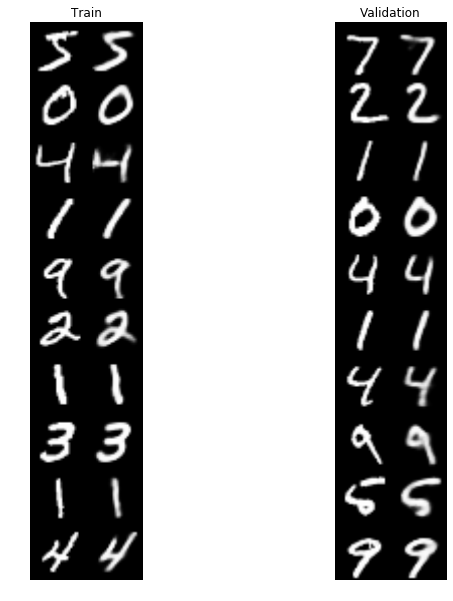

In [96]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (x_data, y_data, title) in enumerate(
            zip([x_train, x_test], [y_train, y_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(cond_x_decoded_mean,
                       feed_dict={x: x_data[:batch_size, :],
                                  label: y_data[:batch_size, :]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = x_data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

## Conditionally hallucinate data
**Task 5.2** Implement the conditional sampling from the distribution $p(x \mid t, \text{label})$ by firstly sampling from the prior $p(t)$ and then sampling from the likelihood $p(x \mid t, \text{label})$.

In [97]:
# Prepare one hot labels of form
#   0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 ...
# to sample five zeros, five ones, etc
curr_labels = np.eye(10)
curr_labels = np.repeat(curr_labels, 5, axis=0)  # Its shape is 50 x 10.
# YOUR CODE HERE.
tensor_labels=tf.convert_to_tensor(curr_labels,dtype=tf.float32)
z=K.random_normal((50,latent_dim)) #sample t (latent variable) from prior
# cond_sampled_im_mean is a tf.Tensor of size 50 x 784 with 5 random zeros,
# then 5 random ones, etc sampled from the cvae model.
cond_sampled_im_mean = cond_decoder(concatenate([z,tensor_labels]))

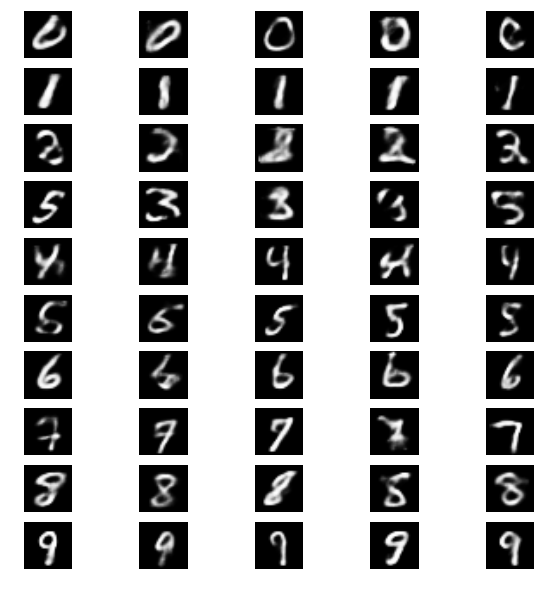

In [98]:
cond_sampled_im_mean_np = sess.run(cond_sampled_im_mean)
# Show the sampled images.
plt.figure(figsize=(10, 10))
global_idx = 0
for digit in range(10):
    for _ in range(5):
        ax = plt.subplot(10, 5, global_idx + 1)
        plt.imshow(cond_sampled_im_mean_np[global_idx, :].reshape(28, 28), cmap='gray')
        ax.axis('off')
        global_idx += 1
plt.show()

In [99]:
# Submit Task 5 (both 5.1 and 5.2).
grader.submit_conditional_hallucinating(sess, cond_sampled_im_mean)

Current answer for task 5.1 (conditional hallucinating mean) is: 0.09307245943314159
Current answer for task 5.2 (conditional hallucinating var) is: 0.050156227740326055


# Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate the token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [102]:
STUDENT_EMAIL = 'darwinsaireonline@gmail.com' # EMAIL HERE
STUDENT_TOKEN = 'sJBKYfGPqEtcljSS' # TOKEN HERE
grader.status()

You want to submit these numbers:
Task 1 (vlb): 157.59676
Task 2.1 (samples mean): -0.122846134
Task 2.2 (samples var): 0.036452327
Task 3 (best val loss): 103.95122276306152
Task 4.1 (hallucinating mean): 0.11096026
Task 4.2 (hallucinating var): 0.17545667
Task 5.1 (conditional hallucinating mean): 0.09307245943314159
Task 5.2 (conditional hallucinating var): 0.050156227740326055


In [103]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Playtime (UNGRADED)
Once you passed all the tests, modify the code below to work with the mixture of Gaussian distributions (in contrast to the mixture of Binomial distributions), and redo the experiments with CIFAR-10 dataset, which are much full color natural images.

In [68]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

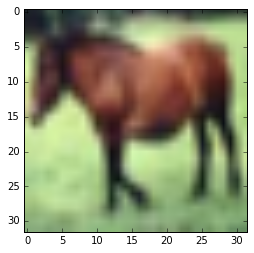

In [69]:
plt.imshow(x_train[7, :])
plt.show()